# Z2 lattice gauge theory

In [1]:
# The C2QA package is currently not published to PyPI.
# To use the package locally, add the C2QA repository's root folder to the path prior to importing c2qa.
import os
import sys
module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Cheat to get MS Visual Studio Code Jupyter server to recognize Python venv
module_path = os.path.abspath(os.path.join("../../venv/Lib/site-packages"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import c2qa
import qiskit
import numpy as np
import scipy
import itertools
import c2qa.util as util
import c2qa.stateReadout as stateReadout
import matplotlib.pyplot as plt
import matplotlib
# Import Qiskit
from qiskit import QuantumCircuit
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
from qiskit.providers.aer import AerSimulator
from qiskit import IBMQ
from collections import Counter

# 1. Testing the controlled phase beamsplitter oscillation

### Create a circuit with as many modes as qubits

In [3]:
numberofmodes=2
numberofqubitspermode=2
cutoff=2**numberofqubitspermode

qmr = c2qa.QumodeRegister(num_qumodes=numberofmodes, num_qubits_per_qumode=numberofqubitspermode)
qbr = qiskit.QuantumRegister(size=1)
cbr = qiskit.ClassicalRegister(size=1)
circuit = c2qa.CVCircuit(qmr, qbr, cbr)
# circuit = c2qa.CVCircuit(qmr)

### Initialise, e.g. share one boson between two cavities by initialising one cavity to Fock state 1 and the other to the vacuum.

In [4]:
diffstallmodes=[1,0]
for i in range(qmr.num_qumodes):
    circuit.cv_initialize(diffstallmodes[i], qmr[i])

In [5]:
def eiht(circuit, qma, qmb, qb, m, g, dt):
    circuit.cv_cpbs(np.pi*dt, qmb, qma, qb)
    # circuit.cv_r(dt*m, qma)
    # circuit.cv_r(dt*m, qmb)
    # circuit.rx(-2*g*dt, qb)
    return circuit

The printed output of util.stateread shows the boson oscillating between the two modes at every time step.

In [6]:
dt=1
m=1
g=1
N=5

circuit.h(qbr[0]) # Inititialises the qubit to a plus state (so that pauli Z flips it)
stateop, _ = c2qa.util.simulate(circuit)
print("Initial state ")
util.stateread(stateop, qbr.size, numberofmodes, cutoff)
print("At each time step")
for i in range(N):
    print("dt+1")
    eiht(circuit, qmr[0], qmr[1], qbr[0], m, g, dt)
    stateop, _ = c2qa.util.simulate(circuit)
    util.stateread(stateop, qbr.size, numberofmodes, cutoff)

Initial state 
qumodes:  01  qubits:  0     with amplitude:  0.7071067811865476
qumodes:  01  qubits:  1     with amplitude:  0.7071067811865475
occupation modes  [0.0, 1.0]
occupation qubits  [0.4999999999999999]
At each time step
dt+1
qumodes:  10  qubits:  0     with amplitude:  -0.7071067811865476
qumodes:  10  qubits:  1     with amplitude:  0.7071067811865475
occupation modes  [1.0, 0.0]
occupation qubits  [0.4999999999999999]
dt+1
qumodes:  01  qubits:  0     with amplitude:  -0.7071067811865476
qumodes:  01  qubits:  1     with amplitude:  -0.7071067811865475
occupation modes  [0.0, 1.0]
occupation qubits  [0.4999999999999999]
dt+1


/home/richard/anaconda3/envs/c2qa/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/home/richard/anaconda3/envs/c2qa/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


qumodes:  10  qubits:  0     with amplitude:  0.7071067811865476
qumodes:  10  qubits:  1     with amplitude:  -0.7071067811865475
occupation modes  [1.0, 0.0]
occupation qubits  [0.4999999999999999]
dt+1
qumodes:  01  qubits:  0     with amplitude:  0.7071067811865476
qumodes:  01  qubits:  1     with amplitude:  0.7071067811865475
occupation modes  [0.0, 1.0]
occupation qubits  [0.4999999999999999]
dt+1
qumodes:  10  qubits:  0     with amplitude:  -0.7071067811865476
qumodes:  10  qubits:  1     with amplitude:  0.7071067811865475
occupation modes  [1.0, 0.0]
occupation qubits  [0.4999999999999999]


Measuring collapses the boson to one mode and the qubit to one state.

In [16]:
circuit.measure(qbr[0],cbr[0])
stateop, result = c2qa.util.simulate(circuit)
util.stateread(stateop, qbr.size, numberofmodes, 4)
print('Counts(ideal):', result.get_counts())

qumodes:  10  qubits:  0     with amplitude:  -1.0
occupation modes  [1.0, 0.0]
occupation qubits  [0.0]
Counts(ideal): {'0': 529, '1': 495}


# 2. Circuit demonstrating mode occupation for Z2LGT (Aidelsburger Nature)
If the beamsplitter term is more important than the flipping of the gauge field, an oscillation and spreading of the boson will occur between the modes.
If the flipping of the gauge field is larger than the boson hopping beamsplitter term, then the qubits will flip backwards and forwards so fast that on average there will be nearly no action of the beamsplitter

### Create a circuit with as many modes as qubits

In [8]:
numberofqubits=4
numberofmodes=5
numberofqubitspermode=2
cutoff=2**numberofqubitspermode

qmr = c2qa.QumodeRegister(num_qumodes=numberofmodes, num_qubits_per_qumode=numberofqubitspermode)
qbr = qiskit.QuantumRegister(size=numberofqubits)
cbr = qiskit.ClassicalRegister(size=1)
circuit = c2qa.CVCircuit(qmr, qbr, cbr)
# circuit = c2qa.CVCircuit(qmr)

### Initialise, e.g. share one boson between the cavities by initialising one cavity to Fock state 1 and the others to the vacuum.

In [9]:
diffstallmodes=[0,0,1,0,0]
for i in range(qmr.num_qumodes):
    circuit.cv_initialize(diffstallmodes[i], qmr[i])

stateop, _ = c2qa.util.simulate(circuit)
occ=util.stateread(stateop, qbr.size, numberofmodes, cutoff)

qumodes:  00100  qubits:  0000     with amplitude:  1.0
occupation modes  [0.0, 0.0, 1.0, 0.0, 0.0]
occupation qubits  [0.0, 0.0, 0.0, 0.0]


In [10]:
def eiht(circuit, qma, qmb, qb, m, g, dt):
    circuit.cv_cpbs(np.pi*dt, qmb, qma, qb)
    # circuit.cv_r(dt*m, qma)
    # circuit.cv_r(dt*m, qmb)
    circuit.rx(-g*dt, qb)
    return circuit

In [13]:
# choice variable decides whether to return the occupation of modes (0) or qubits (1)
def trotterise_Z2LGT(circuit, numberofmodes, numberofqubits, N, choice):
    for i in range(numberofqubits):
        circuit.h(qbr[i]) # Inititialises the qubit to a plus state (so that pauli Z flips it)
    print("initial state ")
    stateop, _ = c2qa.util.simulate(circuit)
    util.stateread(stateop, qbr.size, numberofmodes, cutoff)
    for i in range(N):
        print("dt+1", i*dt)
        for j in range(0,numberofmodes-1,2):
            eiht(circuit, qmr[j+1], qmr[j], qbr[j], m, g, dt)
        for j in range(1,numberofmodes-1,2):
            eiht(circuit, qmr[j+1], qmr[j], qbr[j], m, g, dt)
        stateop, result = c2qa.util.simulate(circuit)
        occupation = util.stateread(stateop, qbr.size, numberofmodes, 4)
        print("occ main ", list(occupation[choice])) # choice is 0 for modes, 1 for qubits
        occs[i]=np.array(list(occupation[choice]))
    return occs

In [ ]:
dt=0.1
m=1
# g=0.1
g=2
N=10
occs=np.zeros((N,numberofmodes))

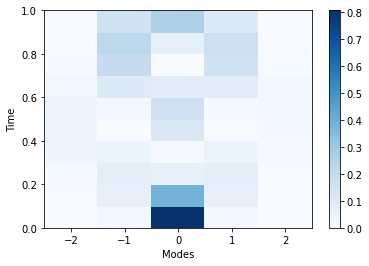

In [12]:
plt.pcolormesh(np.arange(numberofmodes+1)-numberofmodes//2-0.5,np.arange(N+1)*dt,occs,cmap=matplotlib.cm.Blues,linewidth=0,rasterized=True)
plt.xlabel("Modes")
plt.ylabel("Time")
plt.colorbar()

In [ ]:
plt.pcolormesh(np.arange(numberofmodes+1)-numberofmodes//2-0.5,np.arange(N+1)*dt,occs,cmap=matplotlib.cm.Blues,linewidth=0,rasterized=True)
plt.xlabel("Modes")
plt.ylabel("Time")
plt.colorbar()

In [ ]:
circuit.draw(output='mpl', filename='lgt_circuit.png')

In [ ]:
circuit.measure(qbr[0],cbr[0])
stateop, result = c2qa.util.simulate(circuit)
util.stateread(stateop, qbr.size, numberofmodes, 4)
print('Counts(ideal):', result.get_counts())

# 3. Circuit demonstrating qubit state for Z2LGT

### Create a circuit with as many modes as qubits

In [ ]:
numberofqubits=4
numberofmodes=5
numberofqubitspermode=2
cutoff=2**numberofqubitspermode

qmr = c2qa.QumodeRegister(num_qumodes=numberofmodes, num_qubits_per_qumode=numberofqubitspermode)
qbr = qiskit.QuantumRegister(size=numberofqubits)
cbr = qiskit.ClassicalRegister(size=1)
circuit = c2qa.CVCircuit(qmr, qbr, cbr)
# circuit = c2qa.CVCircuit(qmr)

### Initialise, e.g. share one boson between two cavities by initialising one cavity to Fock state 1 and the other to the vacuum.

In [ ]:
diffstallmodes=[0,0,1,0,0]
for i in range(qmr.num_qumodes):
    circuit.cv_initialize(diffstallmodes[i], qmr[i])

stateop, _ = c2qa.util.simulate(circuit)
occ=util.stateread(stateop, qbr.size, numberofmodes, cutoff)

In [ ]:
def eiht(circuit, qma, qmb, qb, m, g, dt):
    circuit.cv_cpbs(np.pi*dt, qmb, qma, qb)
    # circuit.cv_r(dt*m, qma)
    # circuit.cv_r(dt*m, qmb)
    circuit.rx(-g*dt, qb)
    return circuit

In [ ]:
dt=0.1
m=1
g=0.1 # Controlled phase beamsplitter dominates
# g=2 #
N=40
occs=np.zeros((N,numberofqubits))

for i in range(numberofqubits):
    circuit.h(qbr[i]) # Inititialises the qubit to a plus state (so that pauli Z flips it)
print("initial state ")
stateop, _ = c2qa.util.simulate(circuit)
util.stateread(stateop, qbr.size, numberofmodes, cutoff)
for i in range(N):
    print("dt+1", i*dt)
    # Trotterise according to the brickwork format to make depth of circuit 2 and not number of timesteps (because each site needs to be part of a gate with the site to the left and a gate with the site to the right.
    for j in range(0,numberofmodes-1,2):
        eiht(circuit, qmr[j+1], qmr[j], qbr[j], m, g, dt)
    for j in range(1,numberofmodes-1,2):
        eiht(circuit, qmr[j+1], qmr[j], qbr[j], m, g, dt)
    stateop, result = c2qa.util.simulate(circuit)
    omething=util.stateread(stateop, qbr.size, numberofmodes, 4)
    print("occ main ", list(omething))
    occs[i]=np.array(list(omething))

### Controlled phase beamsplitter larger than rotation

In [ ]:
plt.pcolormesh(np.arange(numberofqubits+1)-numberofqubits//2,np.arange(N+1)*dt,occs,cmap=matplotlib.cm.Blues,linewidth=0,rasterized=True)
plt.xlabel("Qubits")
plt.ylabel("Time")
plt.colorbar()

In [ ]:
plt.plot(occs)

In [ ]:
plt.pcolormesh(np.arange(numberofqubits+1)-numberofqubits//2-0.5,np.arange(N+1)*dt,occs,cmap=matplotlib.cm.Blues,linewidth=0,rasterized=True)
plt.xlabel("Qubits")
plt.ylabel("Time")
plt.colorbar()

###  Rotation larger than controlled phase beamsplitter

In [ ]:
plt.pcolormesh(np.arange(numberofqubits+1)-numberofqubits//2-0.5,np.arange(N+1)*dt,occs,cmap=matplotlib.cm.Blues,linewidth=0,rasterized=True)
plt.xlabel("Qubits")
plt.ylabel("Time")
plt.colorbar()

# 3.1. Circuit demonstrating Gauss's law: middle site 2 at t=0

### Create a circuit with as many modes as qubits

In [7]:
numberofqubits=4+1 # the extra one is for the Hadamard test
numberofmodes=5
numberofqubitspermode=2
cutoff=2**numberofqubitspermode

qmr = c2qa.QumodeRegister(num_qumodes=numberofmodes, num_qubits_per_qumode=numberofqubitspermode)
qbr = qiskit.QuantumRegister(size=numberofqubits)
cbr = qiskit.ClassicalRegister(size=1) # To read out the results of the Hadamard test
circuit = c2qa.CVCircuit(qmr, qbr, cbr)
# circuit = c2qa.CVCircuit(qmr)

### Initialise, e.g. share one boson between two cavities by initialising one cavity to Fock state 1 and the other to the vacuum.

In [8]:
diffstallmodes=[0,0,1,0,0]
for i in range(qmr.num_qumodes):
    circuit.cv_initialize(diffstallmodes[i], qmr[i])

circuit.h(qbr[0]) # Hadamard test qubit

stateop, _ = c2qa.util.simulate(circuit)
occ=util.stateread(stateop, qbr.size, numberofmodes, cutoff)

qumodes:  00100  qubits:  00000     with amplitude:  0.7071067811865476
qumodes:  00100  qubits:  00001     with amplitude:  0.7071067811865475
occupation modes  [0.0, 0.0, 1.0, 0.0, 0.0]
occupation qubits  [0.0, 0.0, 0.0, 0.0, 0.4999999999999999]


In [9]:
def eiht(circuit, qma, qmb, qb, m, g, dt):
    circuit.cv_cpbs(np.pi*dt, qmb, qma, qb)
    # circuit.cv_r(dt*m, qma)
    # circuit.cv_r(dt*m, qmb)
    circuit.rx(-g*dt, qb)
    return circuit

In [ ]:
dt=0.1
m=1
g=0.1
# g=2
N=0 # number of timesteps
occs=np.zeros((N,numberofmodes)) # Occupation of each mode at each timestep

for i in range(1,numberofqubits):
    circuit.h(qbr[i]) # Inititialises the qubit to a plus state (so that pauli Z flips it)
# print("initial state ")
# stateop, _ = c2qa.util.simulate(circuit)
# util.stateread(stateop, qbr.size, numberofmodes, cutoff)
# Trotterise. i*dt corresponds to the timestep i of length from the previous timestep dt.
for i in range(N):
    print("dt+1", i*dt)
    # Trotterise according to the brickwork format to make depth of circuit 2 and not number of timesteps (because each site needs to be part of a gate with the site to the left and a gate with the site to the right.
    for j in range(0,numberofmodes-1,2):
        eiht(circuit, qmr[j+1], qmr[j], qbr[j], m, g, dt)
    for j in range(1,numberofmodes-1,2):
        eiht(circuit, qmr[j+1], qmr[j], qbr[j], m, g, dt)

site=1
circuit.cv_qdcr(np.pi, qmr[site], qbr[0])
circuit.cnot(qbr[0],qbr[site])
circuit.cnot(qbr[0],qbr[site+1])
circuit.h(qbr[0])
circuit.measure(0,0)

stateop, result = c2qa.util.simulate(circuit)
# util.stateread(stateop, qbr.size, numberofmodes, 4)
print('Counts(ideal):', result.get_counts())

# 3.2. Circuit demonstrating Gauss's law: other than middle qubits t=0

In [ ]:
def eiht(circuit, qma, qmb, qb, m, g, dt):
    circuit.cv_cpbs(np.pi*dt, qmb, qma, qb)
    # circuit.cv_r(dt*m, qma)
    # circuit.cv_r(dt*m, qmb)
    circuit.rx(-g*dt, qb)
    return circuit

In [ ]:
numberofqubits=4+1 # the extra one is for the Hadamard test
numberofmodes=5
numberofqubitspermode=2
cutoff=2**numberofqubitspermode

qmr = c2qa.QumodeRegister(num_qumodes=numberofmodes, num_qubits_per_qumode=numberofqubitspermode)
qbr = qiskit.QuantumRegister(size=numberofqubits)
cbr = qiskit.ClassicalRegister(size=1) # To read out the results of the Hadamard test
circuit = c2qa.CVCircuit(qmr, qbr, cbr)

diffstallmodes=[0,0,1,0,0]
for i in range(qmr.num_qumodes):
    circuit.cv_initialize(diffstallmodes[i], qmr[i])

for i in range(0,numberofqubits):
    circuit.h(qbr[i])

stateop, result = c2qa.util.simulate(circuit)
util.stateread(stateop, qbr.size, numberofmodes, 4)

site=2
circuit.cv_qdcr(np.pi, qmr[site], qbr[0])
circuit.cnot(qbr[0],qbr[site+1])
circuit.cnot(qbr[0],qbr[site+2])
circuit.h(qbr[0])
circuit.measure(0,0)

stateop, result = c2qa.util.simulate(circuit)
util.stateread(stateop, qbr.size, numberofmodes, 4)
print('Counts(ideal):', result.get_counts())

In [ ]:
numberofqubits=2+1 # the extra one is for the Hadamard test
numberofmodes=3
numberofqubitspermode=2
cutoff=2**numberofqubitspermode

qmr = c2qa.QumodeRegister(num_qumodes=numberofmodes, num_qubits_per_qumode=numberofqubitspermode)
qbr = qiskit.QuantumRegister(size=numberofqubits)
cbr = qiskit.ClassicalRegister(size=1) # To read out the results of the Hadamard test
circuit = c2qa.CVCircuit(qmr, qbr, cbr)

diffstallmodes=[1,0,0]
for i in range(qmr.num_qumodes):
    circuit.cv_initialize(diffstallmodes[i], qmr[i])

for i in range(0,numberofqubits):
    circuit.h(qbr[i])

circuit.cv_qdcr(np.pi, qmr[1], qbr[0])
circuit.cnot(qbr[0],qbr[1])
circuit.cnot(qbr[0],qbr[2])
circuit.h(qbr[0])
circuit.measure(6,0) # measures the qubit at position zero which is after 3 modes each with 2 qubits
# circuit.measure_all()

stateop, result = c2qa.util.simulate(circuit)
util.stateread(stateop, qbr.size, numberofmodes, 4)
print('Counts(ideal):', result.get_counts())

In [ ]:
# Testing qubit dependent cavity rotation

qmr = c2qa.QumodeRegister(num_qumodes=1)
qbr = qiskit.QuantumRegister(size=1)
circuit = c2qa.CVCircuit(qmr, qbr)
zeroQB = np.array([1, 0])
oneQB = np.array([0, 1])
circuit.initialize(zeroQB, qbr[0])
circuit.cv_initialize(1, qmr[0])

circuit.cv_qdcr(np.pi, qmr[0], qbr[0])
stateop, _ = c2qa.util.simulate(circuit)
c2qa.util.stateread(stateop, qbr.size, 1, 4)

In [ ]:
numberofqubits=1 # the extra one is for the Hadamard test
numberofmodes=1
numberofqubitspermode=2
cutoff=2**numberofqubitspermode

qmr = c2qa.QumodeRegister(num_qumodes=numberofmodes, num_qubits_per_qumode=numberofqubitspermode)
qbr = qiskit.QuantumRegister(size=numberofqubits)
cbr = qiskit.ClassicalRegister(size=1) # To read out the results of the Hadamard test
circuit = c2qa.CVCircuit(qmr, qbr, cbr)

circuit.cv_initialize(0, qmr[0])

circuit.h(qbr[0])
# circuit.measure(0,0)

stateop, result = c2qa.util.simulate(circuit)
util.stateread(stateop, qbr.size, numberofmodes, 4)
print('Counts(ideal):', result.get_counts())